# PastureBase Ireland

<https://pasturebase.teagasc.ie>

Hanrahan, L., Geoghegan, A., O'Donovan, M., Griffith, V., Ruelle, E.,
Wallace, M. and Shalloo, L. (2017). 'PastureBase Ireland: A grassland
decision support system and national database',
*Computers and Electronics in Agriculture*, vol. 136, pp. 193-201.
DOI: [10.1016/j.compag.2017.01.029][Hanrahan].

[Hanrahan]: https://doi.org/10.1016/j.compag.2017.01.029

In [1]:
import os
from datetime import datetime, timezone
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cbook import boxplot_stats

In [2]:
DATA_DIR = os.path.join(
    "data", "grass_growth", "pasturebase", "GrowthRateAveragebyWeek.csv"
)

In [3]:
grass = pd.read_csv(DATA_DIR)

In [4]:
grass.head()

Name  Counties_CountyID  Year  WeekNo  AvgGrowth
0  Antrim                  1  2019      37        NaN
1  Armagh                  2  2018      22     126.17
2  Armagh                  2  2018      23      93.01
3  Armagh                  2  2018      24      25.58
4  Armagh                  2  2018      25      35.34

In [5]:
grass.shape

(12455, 5)

In [6]:
list(grass)

['Name', 'Counties_CountyID', 'Year', 'WeekNo', 'AvgGrowth']

In [7]:
grass.sort_values(by=["Name", "Year", "WeekNo"], inplace=True)

In [8]:
# convert year and week number to timestamp
# (Monday as the first day of the week)
grass["Timestamp"] = grass.apply(
    lambda row: datetime.strptime(
        str(row.Year) + "-" + str(row.WeekNo) + "-1", "%G-%V-%u"
    ),
    axis=1,
)

In [9]:
# create time series using counties as individual columns
grass.drop(columns=["Counties_CountyID"], inplace=True)

In [11]:
grass.head()

Name  Year  WeekNo  AvgGrowth  Timestamp
0  Antrim  2019      37        NaN 2019-09-09
1  Armagh  2018      22     126.17 2018-05-28
2  Armagh  2018      23      93.01 2018-06-04
3  Armagh  2018      24      25.58 2018-06-11
4  Armagh  2018      25      35.34 2018-06-18

In [12]:
grass_ts = pd.pivot_table(
    grass[["Name", "AvgGrowth", "Timestamp"]],
    values="AvgGrowth",
    index=["Timestamp"],
    columns=["Name"],
)

In [13]:
grass_ts.shape

(508, 30)

In [14]:
grass_ts["time"] = grass_ts.index

In [15]:
grass_ts.sort_values(by=["time"], inplace=True)

In [16]:
grass_ts.head()

Name        Armagh  Carlow  Cavan  Clare   Cork  Derry  Donegal  Down  Dublin  \
Timestamp                                                                       
2012-12-31     NaN     NaN   0.39    NaN   1.10    NaN      NaN   NaN     NaN   
2013-01-07     NaN     NaN   4.33   4.94   4.97    NaN      NaN   NaN     NaN   
2013-01-14     NaN     NaN    NaN    NaN   4.46    NaN      NaN   NaN     NaN   
2013-01-21     NaN     NaN    NaN   2.42  10.11    NaN      NaN   NaN     NaN   
2013-01-28     NaN    5.03   4.80    NaN   7.67    NaN      NaN   NaN     NaN   

Name        Galway  ...  Offaly  Roscommon  Sligo  Tipperary  Tyrone  \
Timestamp           ...                                                
2012-12-31    1.71  ...     NaN        NaN    NaN      17.05     NaN   
2013-01-07    0.00  ...     NaN        NaN    NaN       3.66     NaN   
2013-01-14    7.14  ...     NaN        NaN    NaN       5.43     NaN   
2013-01-21    0.00  ...     NaN        NaN   3.45       5.00     NaN   
2013-01-28    6.87  ...     NaN        NaN    NaN       5.11     NaN   

Name        Waterford  Westmeath  Wexford  Wicklow       time  
Timestamp                                                      
2012-12-31        NaN        NaN      NaN     3.36 2012-12-31  
2013-01-07       8.76        NaN      NaN      NaN 2013-01-07  
2013-01-14       3.22        NaN     3.47      NaN 2013-01-14  
2013-01-21       3.89        NaN     6.02      NaN 2013-01-21  
2013-01-28       4.64        NaN      NaN     3.37 2013-01-28  

[5 rows x 31 columns]

In [17]:
# drop NI counties
grass_ts.drop(columns=["Armagh", "Derry", "Down", "Tyrone"], inplace=True)

In [18]:
# use weekly time series starting on Monday to fill missing rows
grass_ = pd.DataFrame(
    pd.date_range(
        str(grass_ts["time"][0].year) + "-01-01",
        str(grass_ts["time"][len(grass_ts) - 1].year) + "-12-31",
        freq="W-MON",
    ),
    columns=["time"],
)

In [19]:
grass_ts = pd.merge(grass_, grass_ts, how="outer")

In [20]:
grass_ts.index = grass_ts["time"]

In [21]:
grass_ts.drop(columns=["time"], inplace=True)

In [22]:
grass_ts.shape

(574, 26)

In [24]:
# new colour map
# https://stackoverflow.com/a/31052741
# sample the colormaps that you want to use. Use 15 from each so we get 30
# colors in total
colors1 = plt.cm.tab20b(np.linspace(0.0, 1, 15))
colors2 = plt.cm.tab20c(np.linspace(0, 1, 15))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))

## Distribution

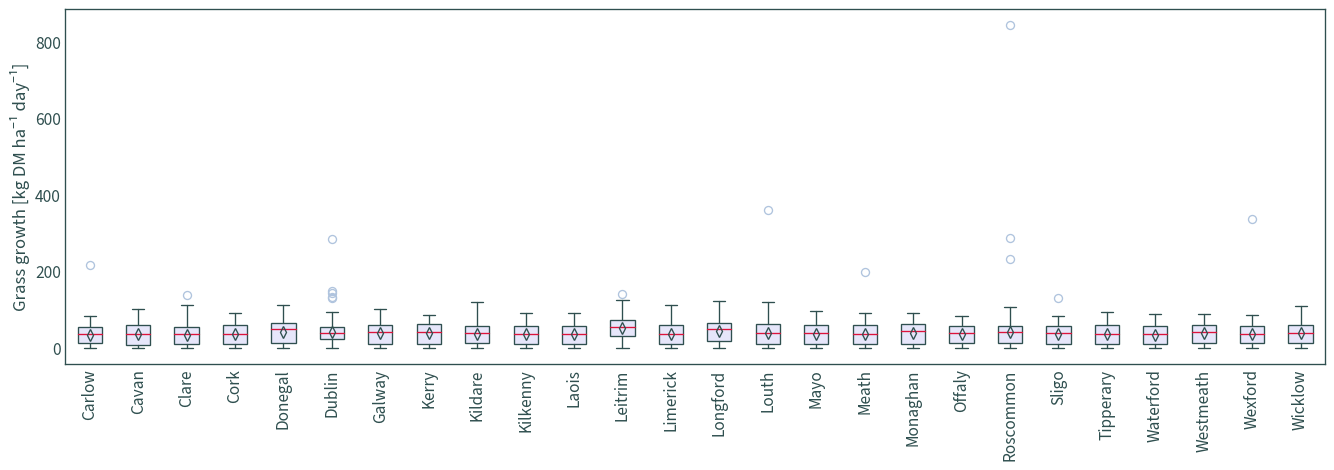

In [25]:
# with outliers
grass_ts.plot.box(
    figsize=(14, 5),
    showmeans=True,
    patch_artist=True,
    color={
        "medians": "Crimson",
        "whiskers": "DarkSlateGrey",
        "caps": "DarkSlateGrey",
    },
    boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
    meanprops={
        "markeredgecolor": "DarkSlateGrey",
        "marker": "d",
        "markerfacecolor": (1, 1, 0, 0),  # transparent
    },
    flierprops={"markeredgecolor": "LightSteelBlue", "zorder": 1},
)
plt.xticks(rotation="vertical")
plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.tight_layout()
# plt.savefig(
#     os.path.join(
#         "data", "grass_growth", "pasturebase", "boxplot_outliers.png"
#     )
# )
plt.show()

## Time series

In [29]:
counties = list(grass_ts)

In [30]:
# pivot table for plotting
grass_piv = grass_ts.copy()
grass_piv["year"] = grass_piv.index.year
grass_piv["weekno"] = grass_piv.index.isocalendar().week
grass_piv = pd.pivot_table(grass_piv, index="weekno", columns="year")

In [31]:
grass_piv.head()

Carlow                                                            \
year     2013   2014   2015    2016   2017   2018    2019   2020   2021   
weekno                                                                    
1         NaN   4.90    NaN     NaN   3.56   5.16   4.635    NaN    NaN   
2         NaN    NaN    NaN     NaN    NaN   8.25   7.830    NaN    NaN   
3         NaN    NaN    NaN    7.57   2.97   3.98   8.610    NaN   3.25   
4         NaN    NaN    NaN    5.14   2.16  20.05   9.300   3.76  13.59   
5        5.03   4.11   3.80     NaN    NaN   4.31   8.650   3.33   3.16   
6         NaN    NaN   3.50    0.74   4.35   5.20   8.790   5.64   3.68   
7         NaN    NaN   2.07    0.00  10.19   3.64   6.720   3.44   2.63   
8       14.40   7.73   3.16     NaN   9.76   6.31   7.080   5.35   6.38   
9        7.15    NaN   3.51    5.83  12.97   1.94  14.630   7.19   6.16   
10       8.59   6.20  12.36    6.49  17.16   4.30  19.380   9.12  14.76   
11      11.53  11.54   9.34    9.59  14.15   1.55  14.520  12.69  10.99   
12      10.62  14.92  13.48   12.94  29.57   9.46  28.140  16.59  15.91   
13      10.11  17.97  18.43   12.89  29.32   8.41  22.920  17.22  27.74   
14       6.74  27.54  16.96  218.31  36.72  11.69  25.220  22.36  37.10   
15      10.96  28.29  32.26   30.21  38.20  20.44  25.210  39.46  42.83   
16      14.96  38.19  39.05   33.17  50.56  44.45  33.400  52.13  35.67   
17      32.35  43.56  59.42   36.16  54.78  61.83  55.400  65.82  47.20   
18      42.62  50.26  44.75   39.94  48.45  55.51  69.290  61.86  49.68   
19      48.45  48.46  44.17   44.28  57.79  62.89  57.930  61.98  62.51   
20      46.13  59.81  61.64   74.84  58.34  66.17  60.420  59.36  57.76   
21      51.25  59.40  58.83   83.00  77.29  83.54  67.490  47.78  70.53   
22      44.28  75.11  63.11   68.60  81.22  71.60  69.960  73.73  71.14   
23      58.14  59.43  59.93   78.92  67.68  70.16  73.260  36.77  81.54   
24      50.47  70.67  63.39   57.46  66.53  44.06  59.670  35.36  79.01   
25      49.41  73.66  62.46   64.87  62.64  36.11  54.830  41.15  67.93   
26      60.67  53.59  54.06   63.79  56.68  29.13  65.170  58.01  45.44   
27      38.29  47.75  43.12   66.39  62.96  17.66  65.950  77.71  54.64   
28      54.03  44.82  52.23   68.11  69.82  14.75  44.810  69.82  52.93   
29      20.31  44.90  59.74   51.68  51.38  20.47  36.970  72.50  57.67   
30       9.67  52.36  59.55   70.17  72.64  10.98  40.150  64.57  47.26   
31      19.44  40.31  57.15   43.76  65.00  30.51  50.670  63.57  26.17   
32      62.28  22.45  66.82   47.53  58.08  36.32  46.220  61.88  43.79   
33      71.13  41.93  53.34   42.01  63.32  46.17  53.280  66.97  53.48   
34      48.44  52.50  54.56   29.55  61.95  35.14  59.410  60.48  70.76   
35      40.49  45.48  57.85   42.76  70.09  61.68  61.340  54.74  54.61   
36      15.02  49.39  55.69   55.31  65.25  42.19  54.610  58.14  48.64   
37      18.82  51.07  48.06   55.17  61.79  52.10  50.880  57.57  46.64   
38      17.89  49.14  45.24   52.05  48.04  51.04  47.530  59.82  44.88   
39      23.76  37.84  47.11   59.79  61.75  51.72  43.210  51.92  47.82   
40      23.28  42.90  49.60   50.44  40.26  41.00  47.270  36.57  41.13   
41      43.42  38.52  40.77   41.97  37.17  41.55  45.120  49.81  37.41   
42      40.67  32.17  38.15   41.27  40.00  36.73  28.400  24.79  31.92   
43      33.25  32.67  30.21   33.88  29.95  29.21  21.910  27.05  31.78   
44      24.23  24.39  29.56   26.44  23.32  23.18  25.600  18.57  31.23   
45      26.06  22.42  19.91   25.25  20.21  17.13  13.040  16.72  21.85   
46      14.26  16.66  21.85   17.62  25.93  22.43  13.390  18.63  15.61   
47      16.43   7.27  12.43   13.43    NaN  15.97  10.320  17.12  14.64   
48       8.93    NaN   1.87   14.17  29.64  17.77   5.580   8.04  15.79   
49       6.09   8.15  12.22   12.76   9.05   8.49  10.530  15.74  11.15   
50        NaN    NaN   6.61     NaN    NaN  10.12   6.880   5.08   9.23   
51        NaN    NaN  14.11    4

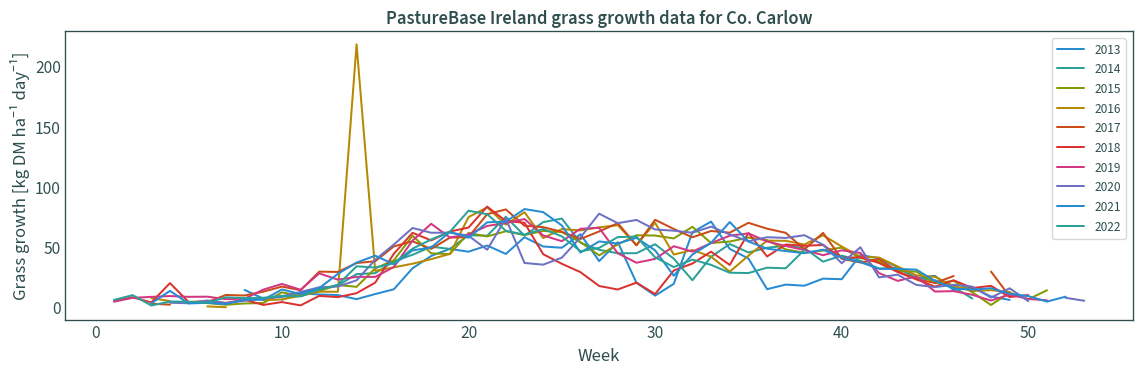

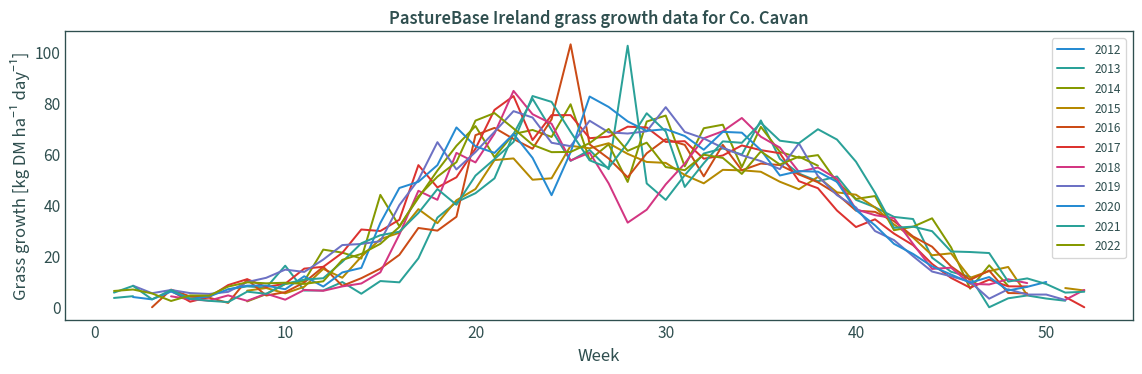

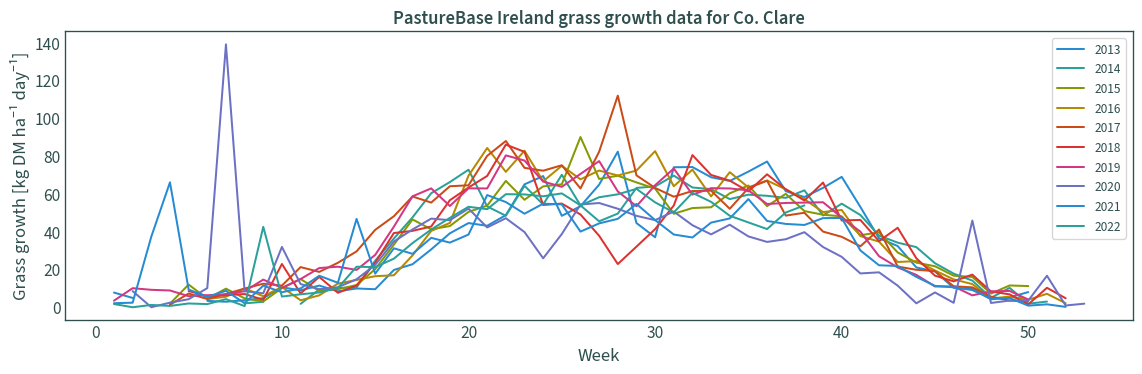

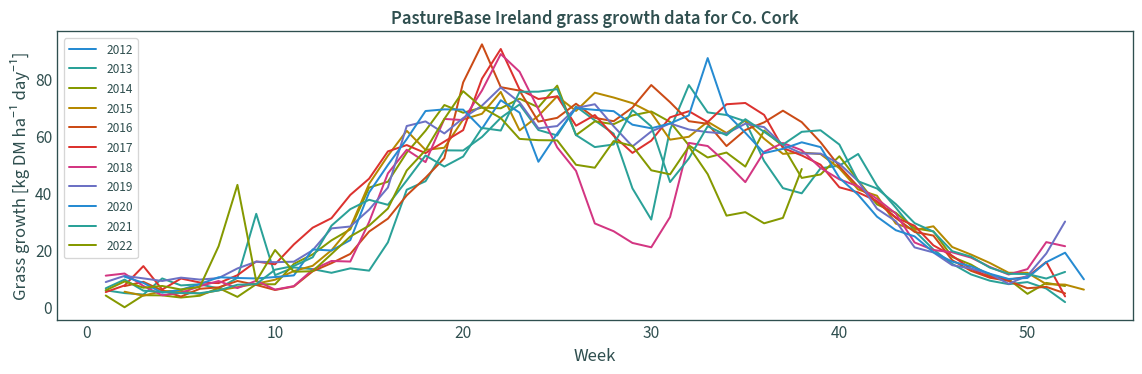

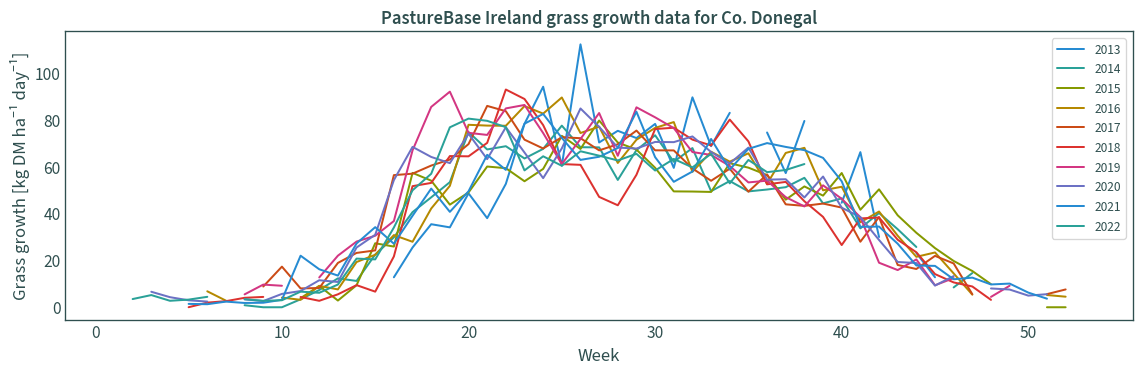

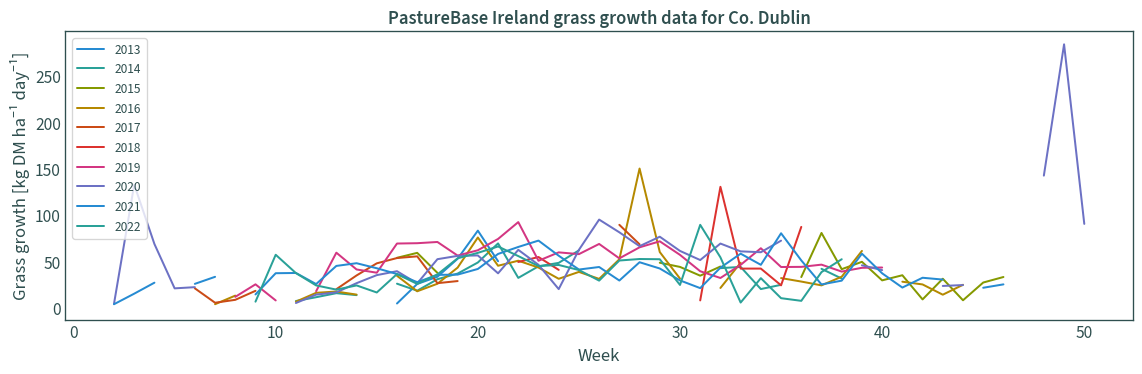

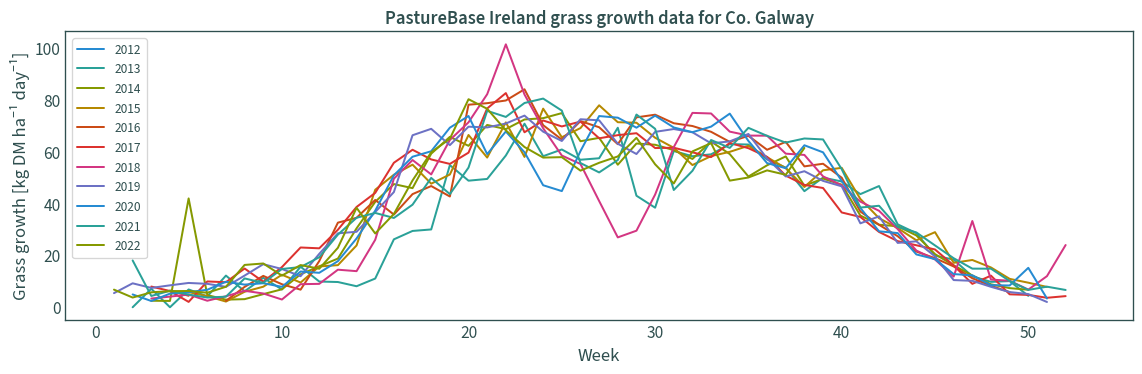

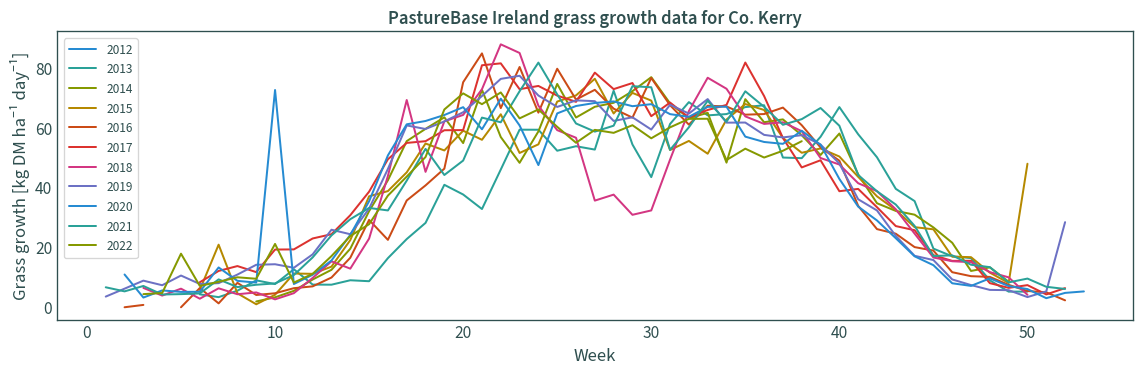

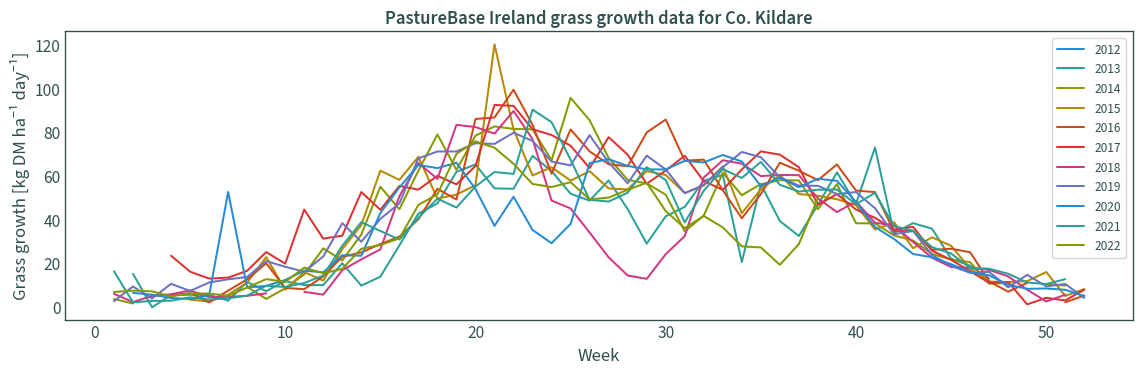

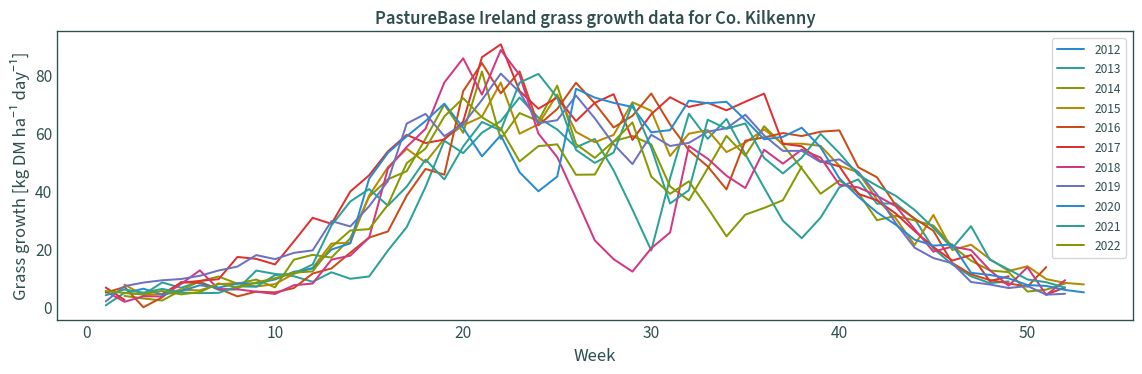

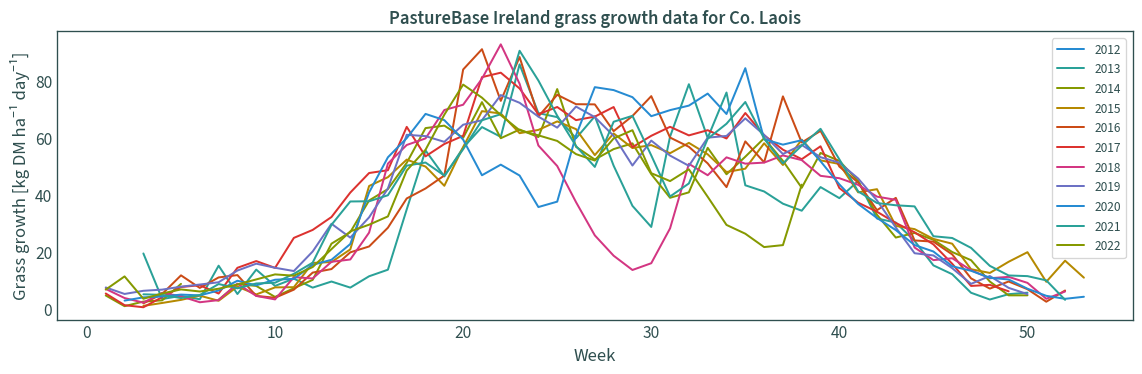

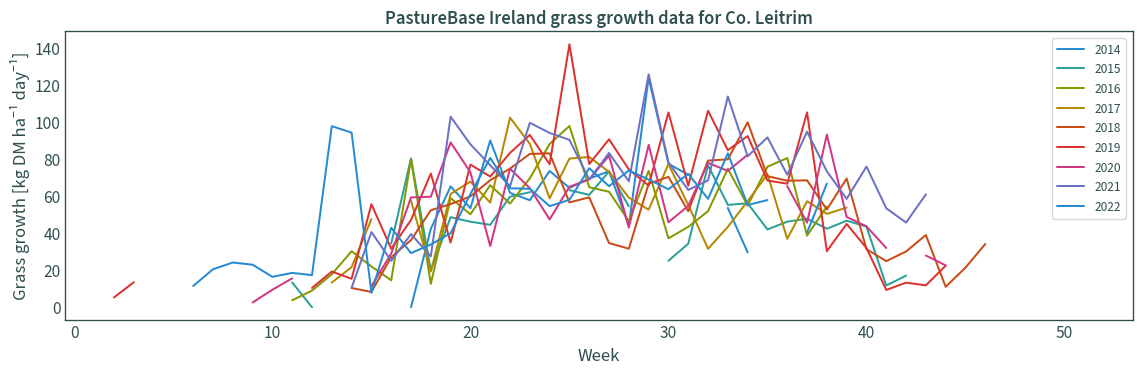

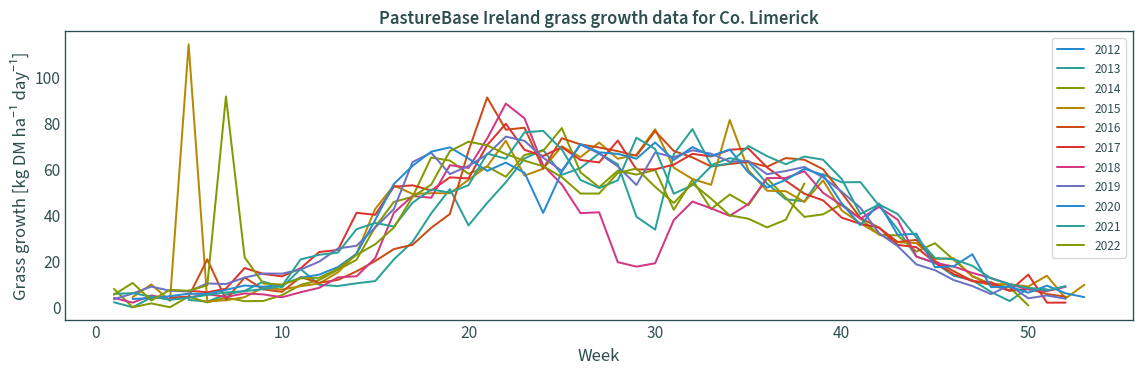

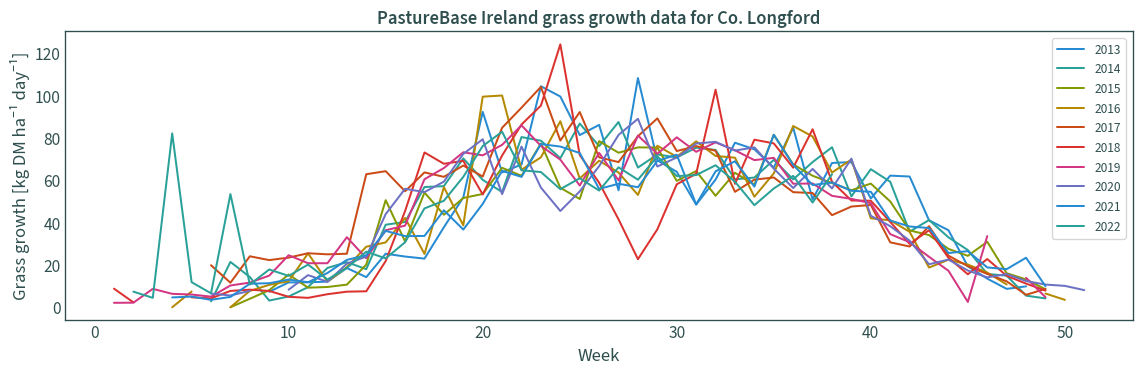

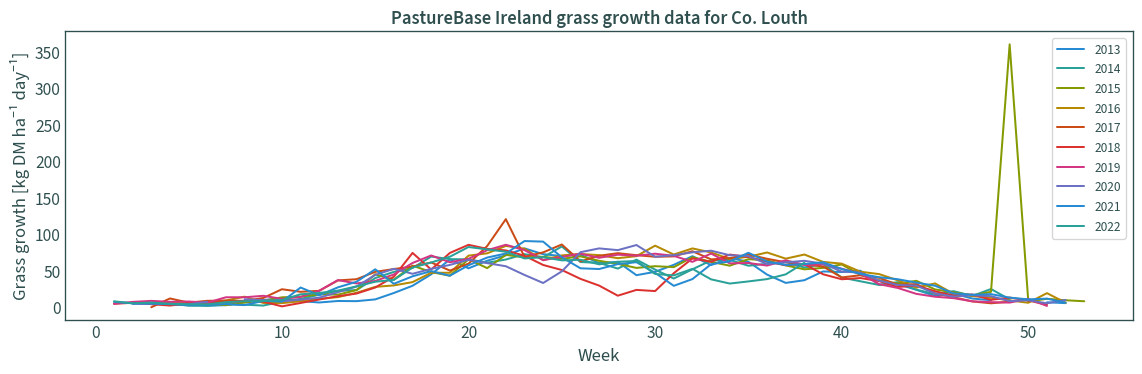

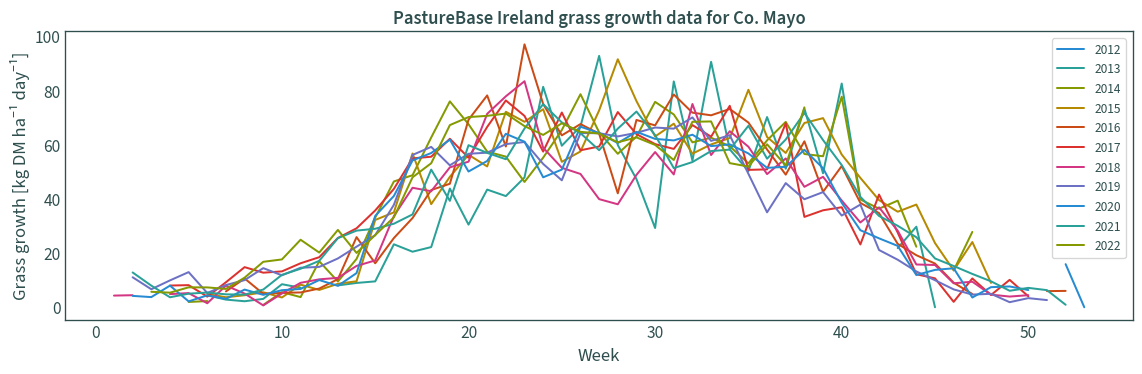

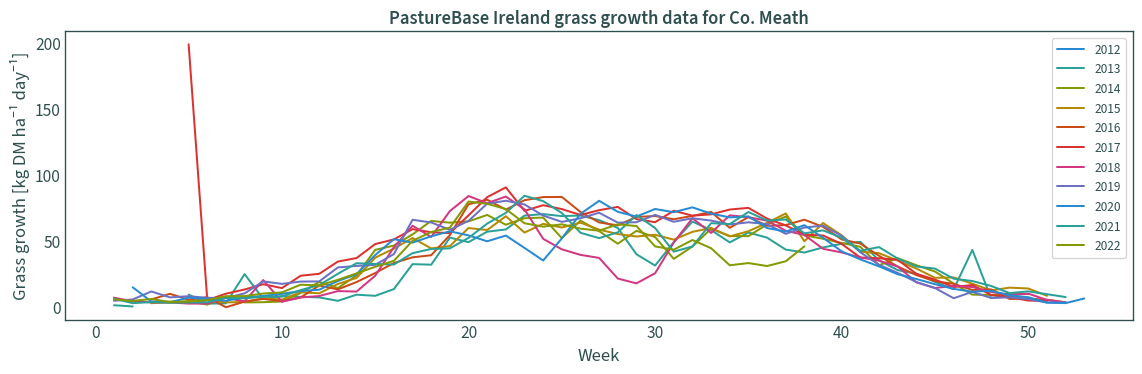

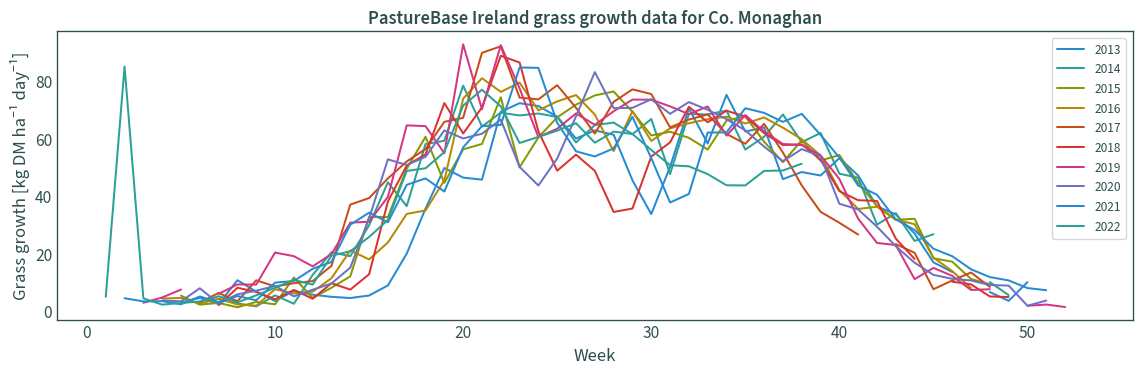

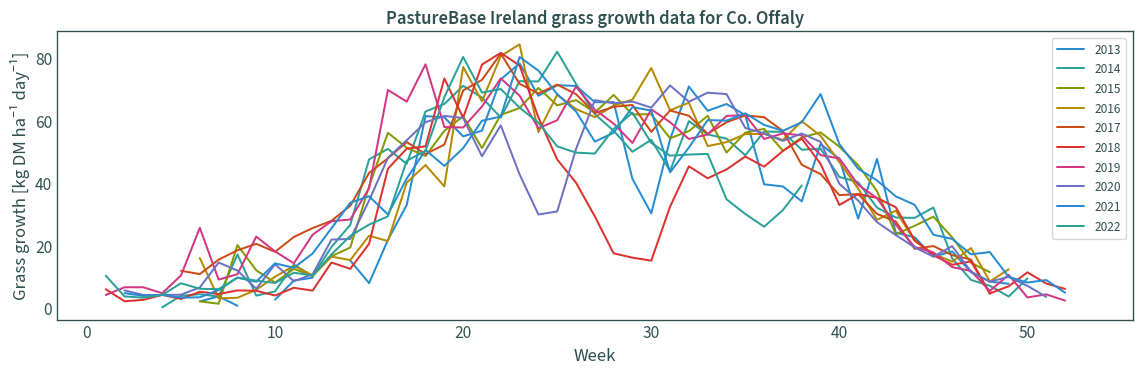

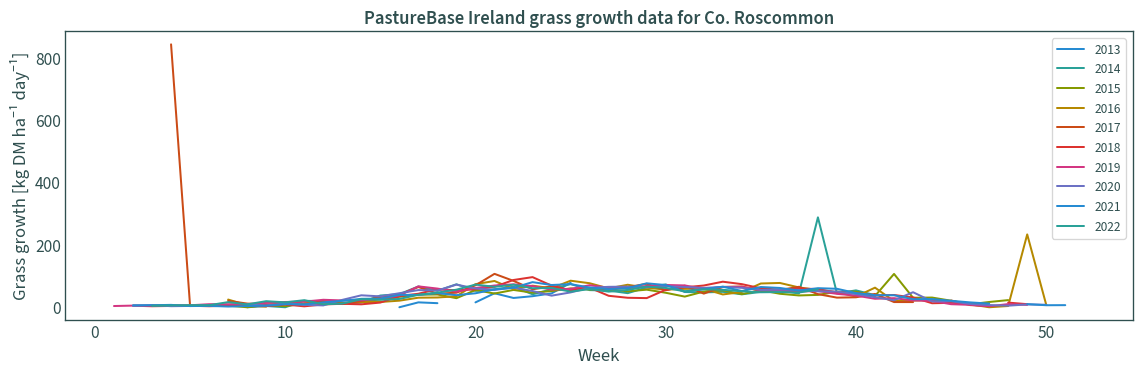

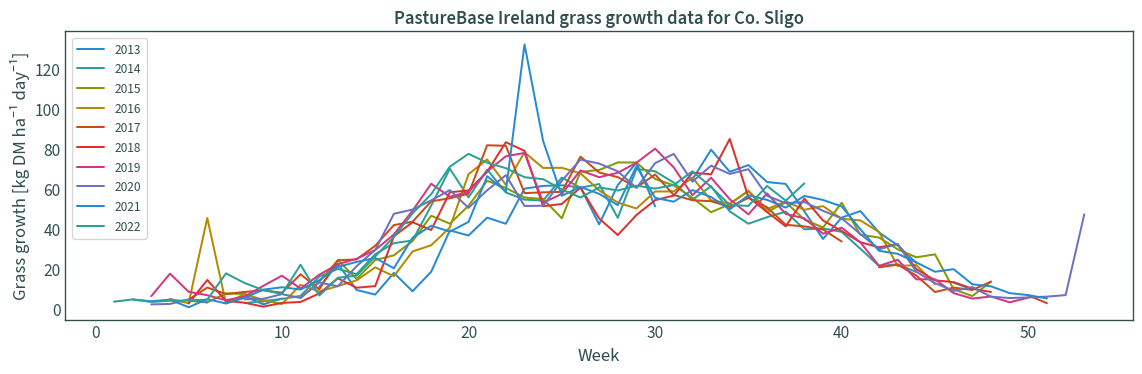

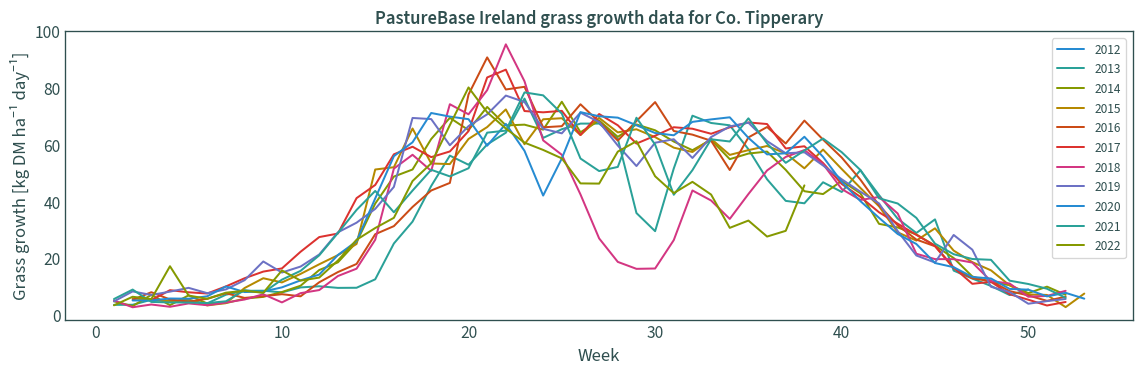

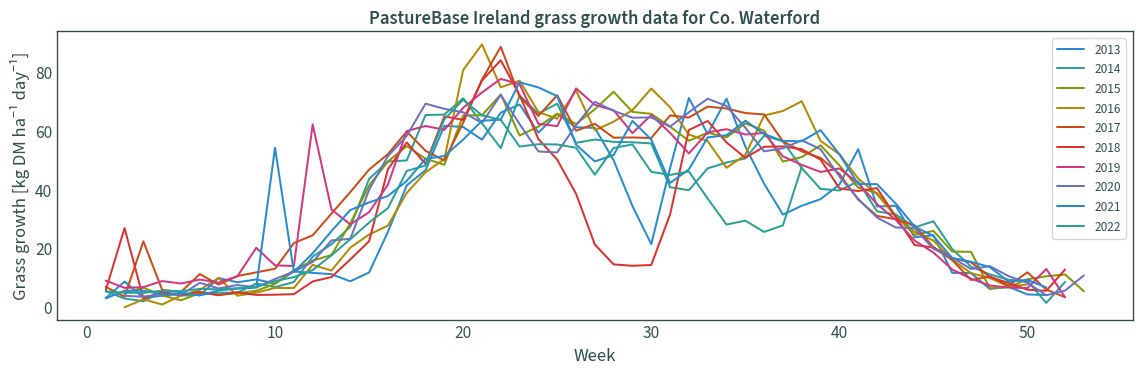

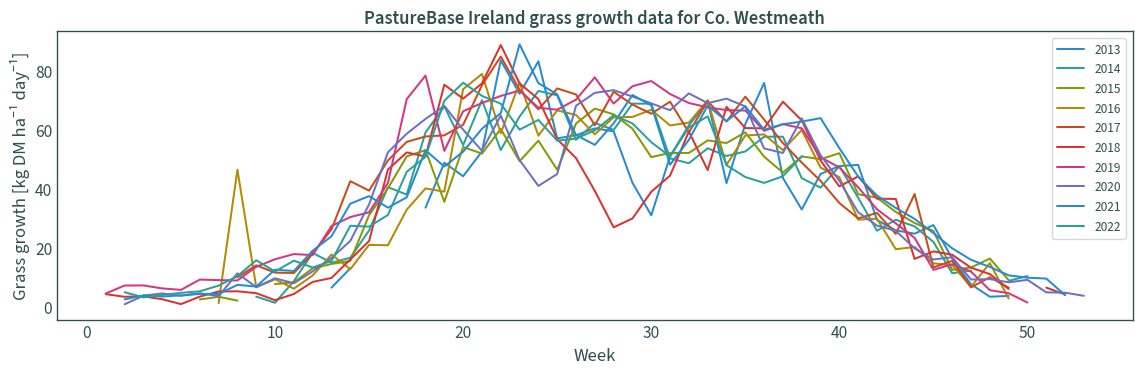

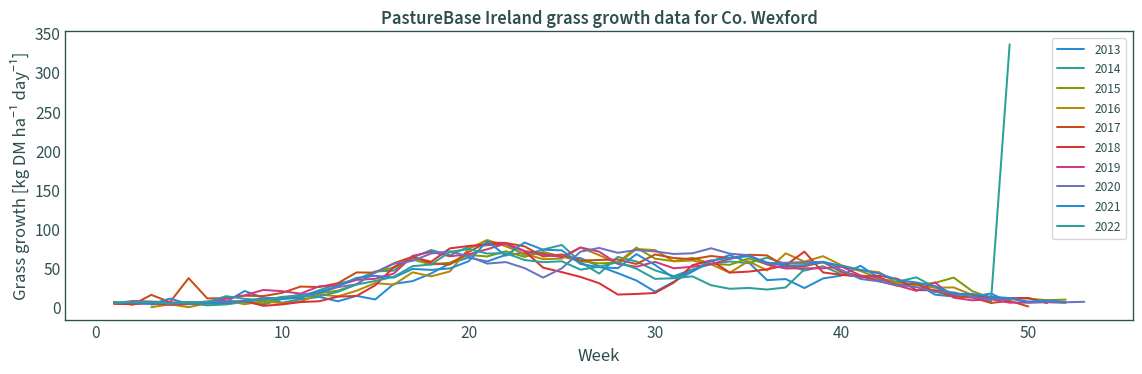

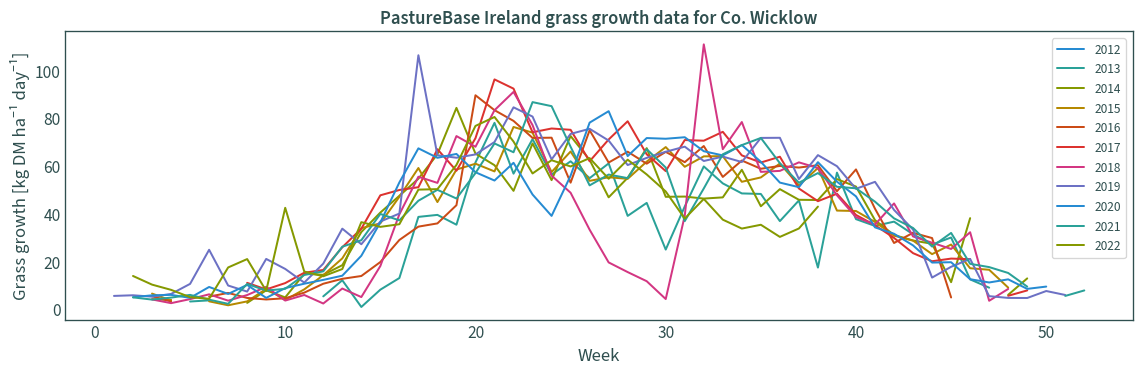

In [32]:
for county in counties:
    grass_piv[county].plot(
        figsize=(12, 4),
        xlabel="Week",
        ylabel="Grass growth [kg DM ha⁻¹ day⁻¹]",
    )
    plt.title(f"PastureBase Ireland grass growth data for Co. {county}")
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

## Filtering outliers in distribution

In [144]:
grass_filter = grass_ts.melt(ignore_index=False)

In [145]:
grass_filter["weekno"] = grass_filter.index.isocalendar().week

In [146]:
grass_filter

variable  value  weekno
time                              
2012-01-02   Carlow    NaN       1
2012-01-09   Carlow    NaN       2
2012-01-16   Carlow    NaN       3
2012-01-23   Carlow    NaN       4
2012-01-30   Carlow    NaN       5
...             ...    ...     ...
2022-11-28  Wicklow    NaN      48
2022-12-05  Wicklow    NaN      49
2022-12-12  Wicklow    NaN      50
2022-12-19  Wicklow    NaN      51
2022-12-26  Wicklow    NaN      52

[14924 rows x 3 columns]

In [147]:
# filter all values over 180
grass_filter["value"] = np.where(
    grass_filter["value"] < 180, grass_filter["value"], np.nan
)

In [148]:
# filter all values over 60 when the week number is below 11
grass_filter["value"] = np.where(
    (grass_filter["weekno"] < 11) & (grass_filter["value"] > 60),
    np.nan,
    grass_filter["value"],
)

In [149]:
# filter all values over 40 when the week value is over 47
grass_filter["value"] = np.where(
    (grass_filter["weekno"] > 47) & (grass_filter["value"] > 40),
    np.nan,
    grass_filter["value"],
)

In [150]:
grass_filter

variable  value  weekno
time                              
2012-01-02   Carlow    NaN       1
2012-01-09   Carlow    NaN       2
2012-01-16   Carlow    NaN       3
2012-01-23   Carlow    NaN       4
2012-01-30   Carlow    NaN       5
...             ...    ...     ...
2022-11-28  Wicklow    NaN      48
2022-12-05  Wicklow    NaN      49
2022-12-12  Wicklow    NaN      50
2022-12-19  Wicklow    NaN      51
2022-12-26  Wicklow    NaN      52

[14924 rows x 3 columns]

In [152]:
# pivot table for plotting
grass_piv = pd.pivot_table(
    grass_filter[["variable", "value"]].reset_index(),
    values="value",
    index=["time"],
    columns=["variable"],
)
grass_piv["year"] = grass_piv.index.year
grass_piv["weekno"] = grass_piv.index.isocalendar().week
grass_piv = pd.pivot_table(grass_piv, index="weekno", columns="year")

In [155]:
grass_piv.tail()

variable Carlow                                                             \
year       2013  2014   2015   2016  2017   2018   2019   2020   2021 2022   
weekno                                                                       
49         6.09  8.15  12.22  12.76  9.05   8.49  10.53  15.74  11.15  NaN   
50          NaN   NaN   6.61    NaN   NaN  10.12   6.88   5.08   9.23  NaN   
51          NaN   NaN  14.11   4.13  8.24    NaN   5.76    NaN   4.71  NaN   
52          NaN   NaN    NaN    NaN   NaN    NaN    NaN   7.83   8.81  NaN   
53          NaN   NaN   8.09    NaN   NaN    NaN    NaN   5.39    NaN  NaN   

variable  ... Wicklow                                                       
year      ...    2013   2014 2015   2016  2017 2018  2019  2020  2021 2022  
weekno    ...                                                               
49        ...    3.25  13.04  NaN   8.85  8.01  NaN  4.84  8.66  9.60  NaN  
50        ...     NaN    NaN  NaN    NaN   NaN  NaN  7.76  9.62   NaN  NaN  
51        ...     NaN    NaN  NaN  10.89   NaN  NaN  6.10   NaN  5.71  NaN  
52        ...     NaN    NaN  NaN    NaN   NaN  NaN   NaN   NaN  8.00  NaN  
53        ...     NaN    NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN  NaN  

[5 rows x 271 columns]

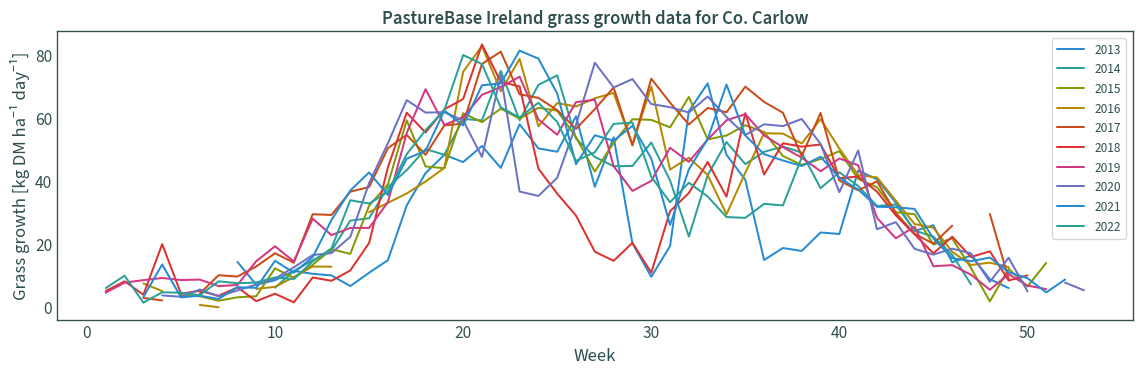

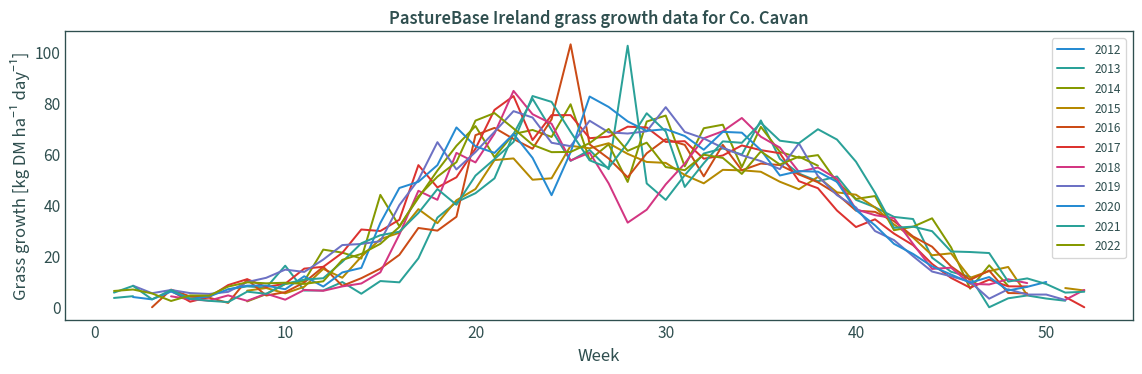

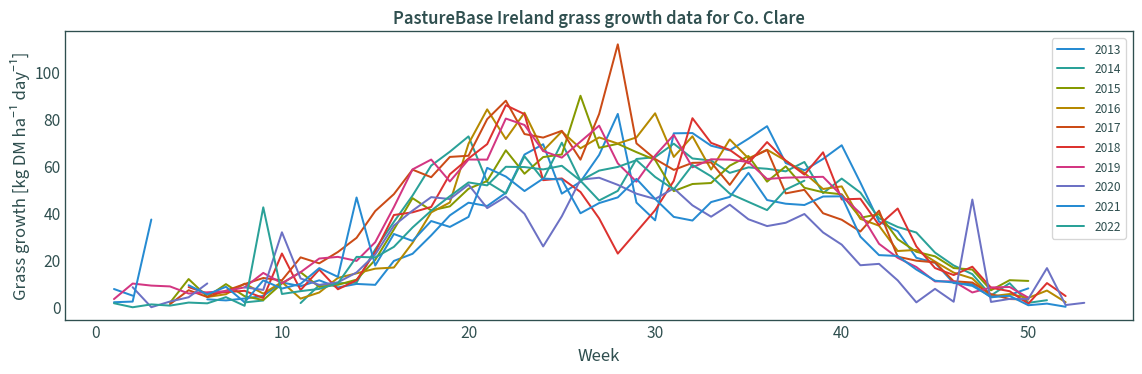

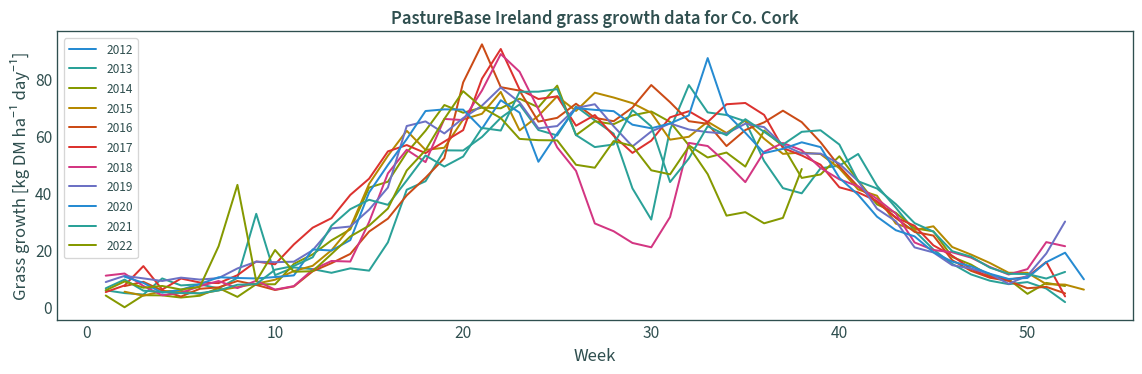

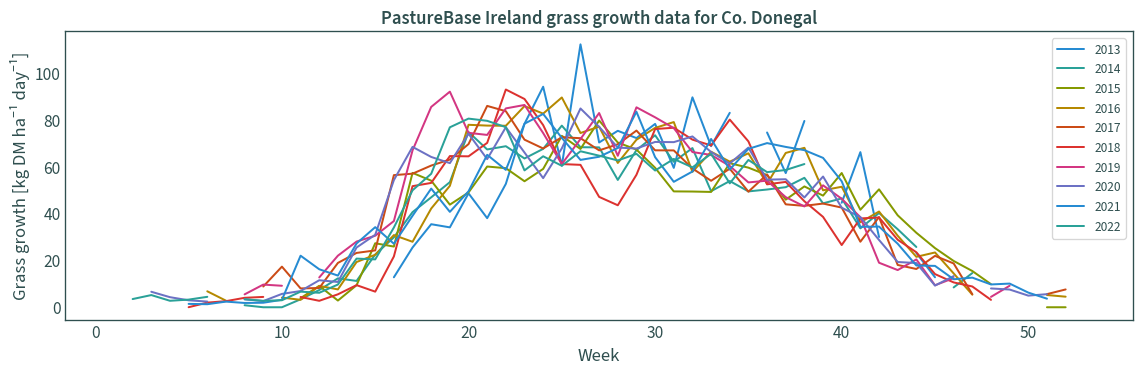

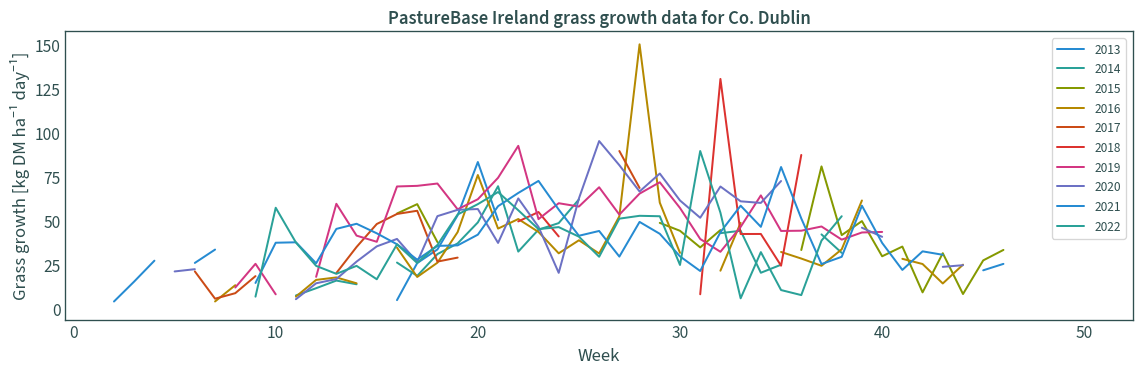

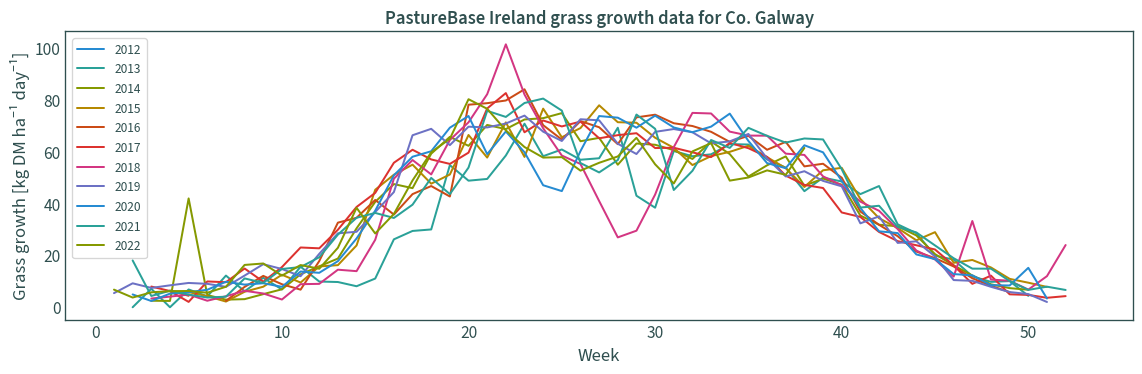

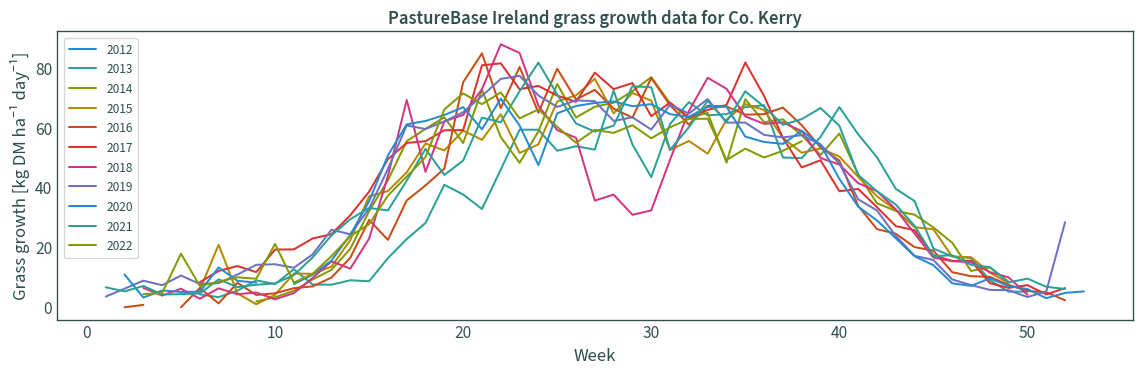

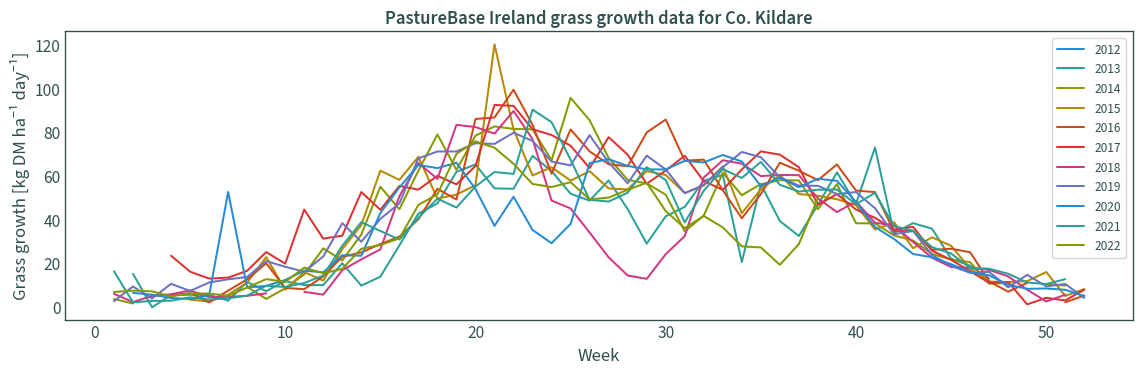

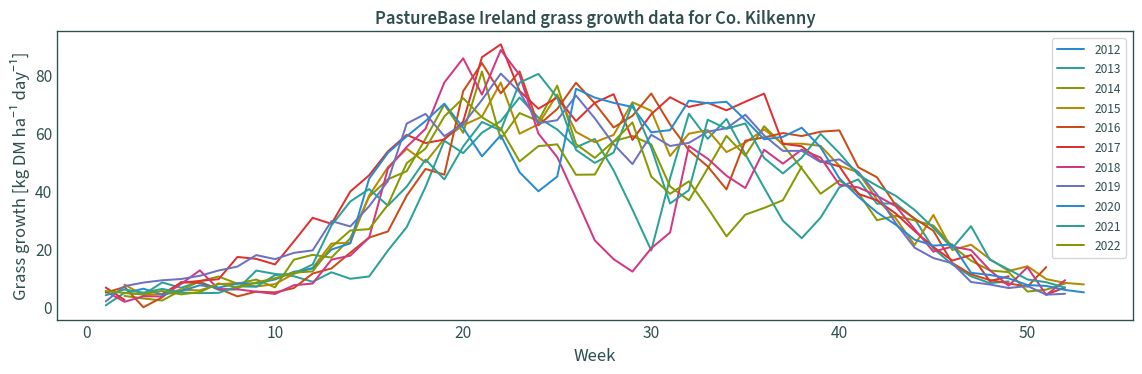

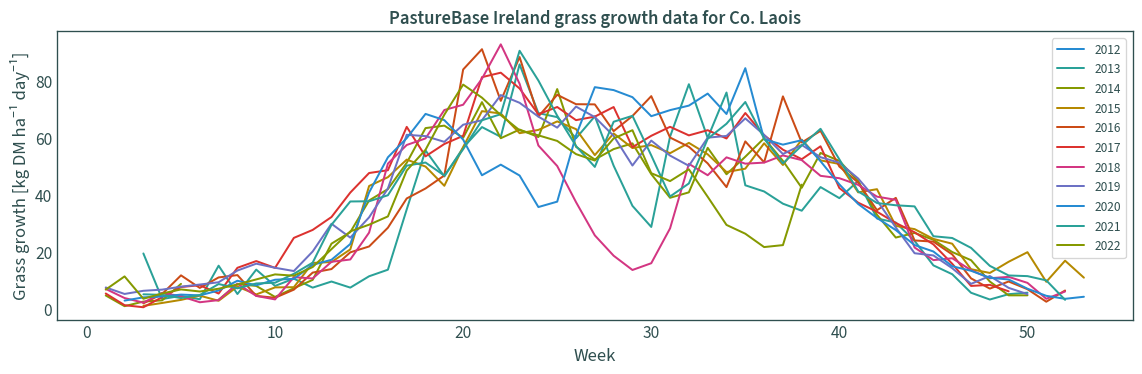

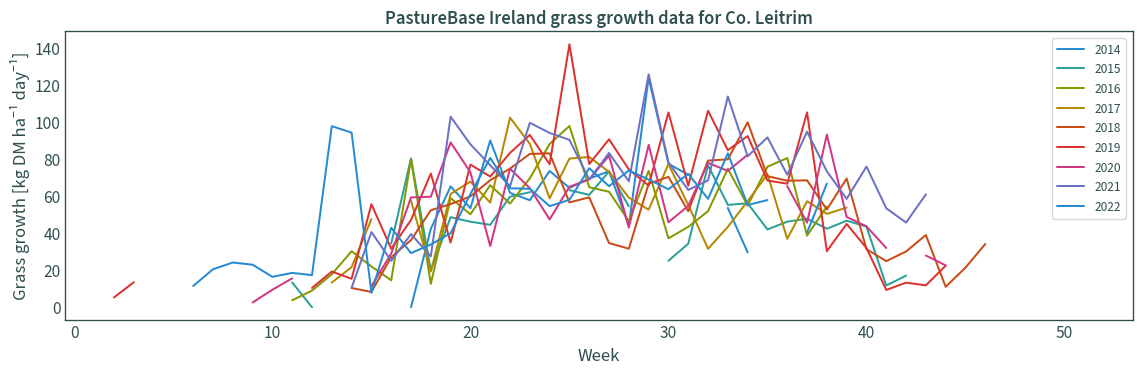

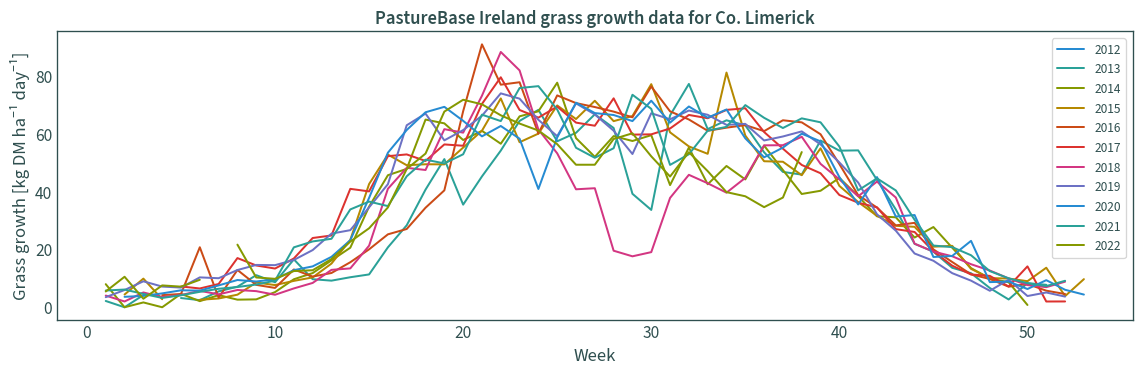

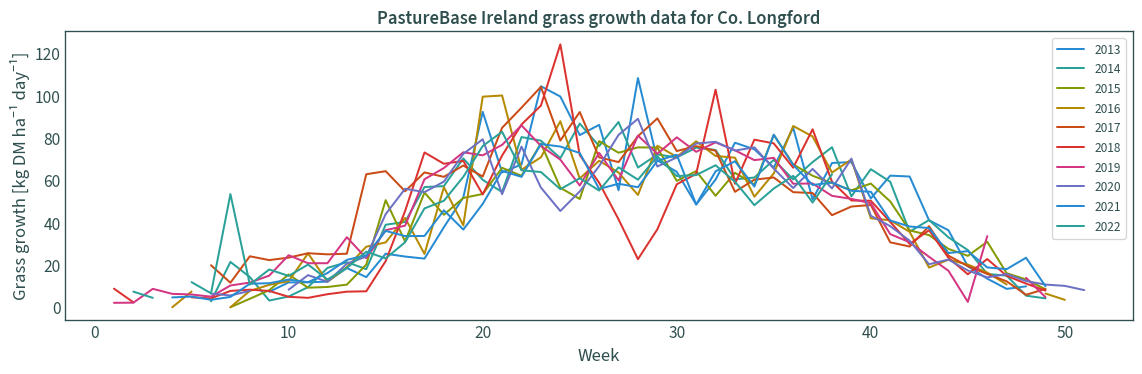

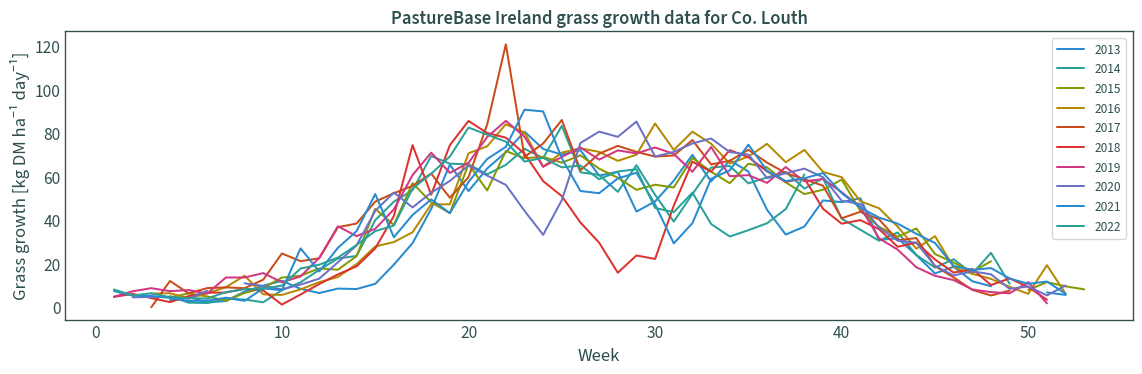

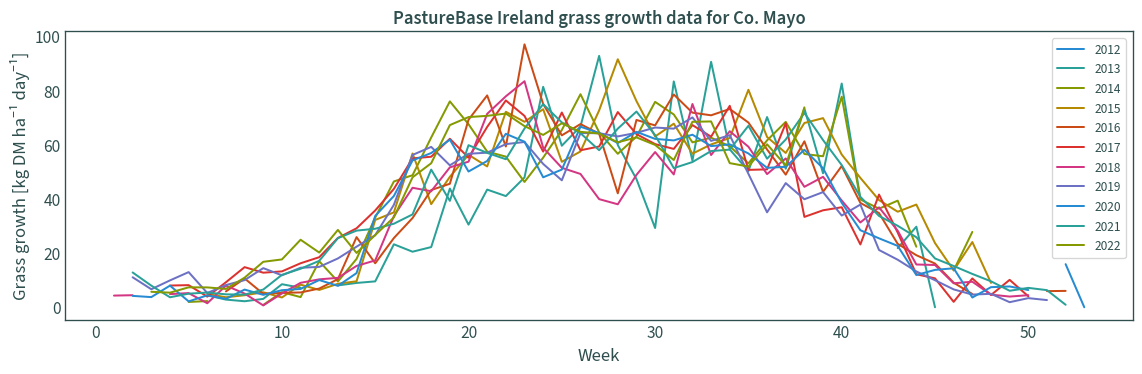

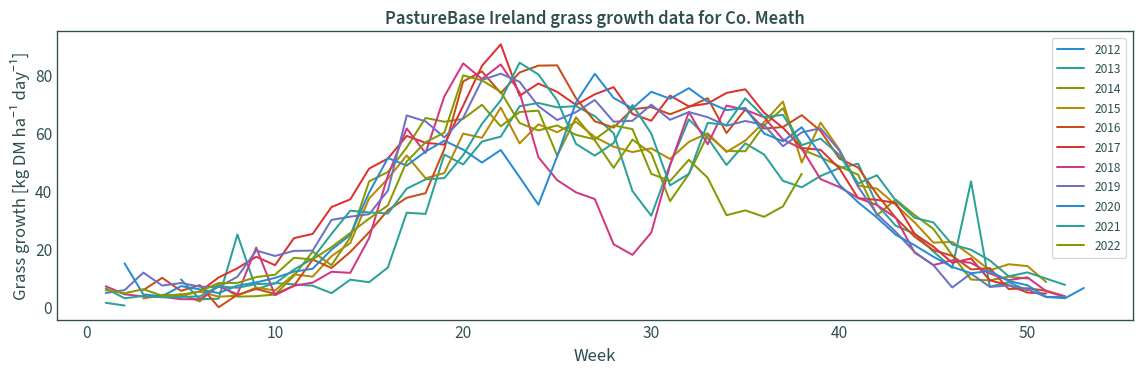

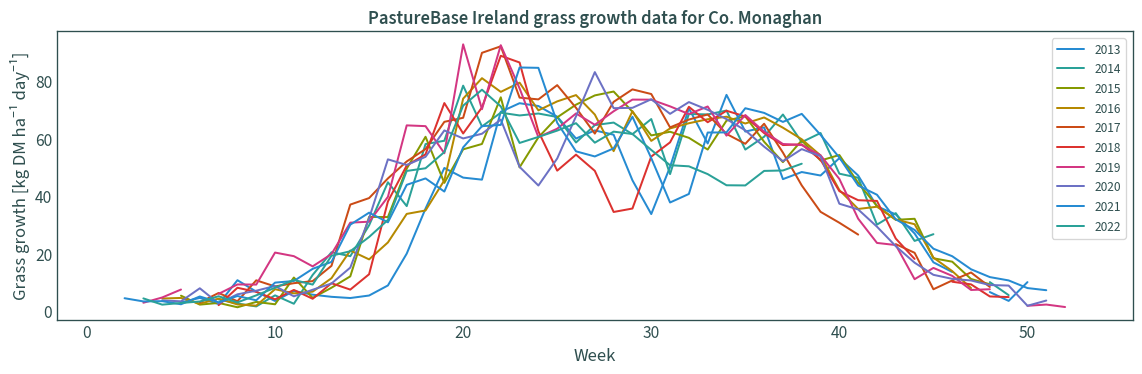

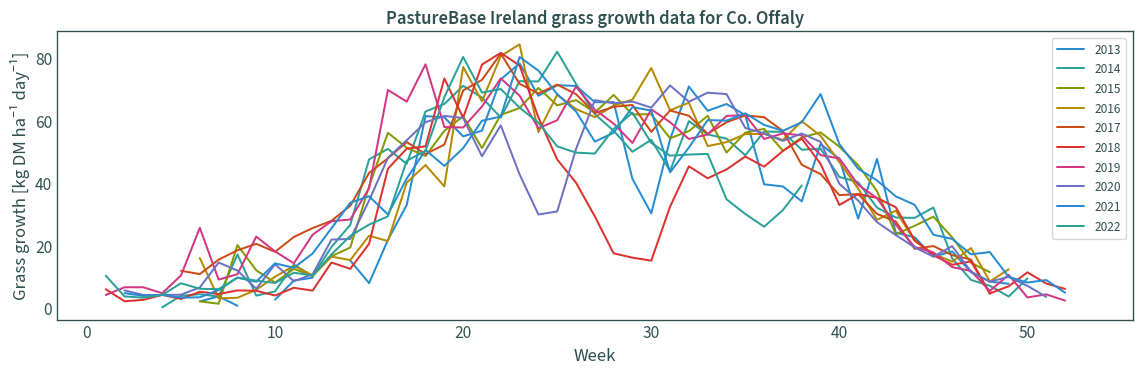

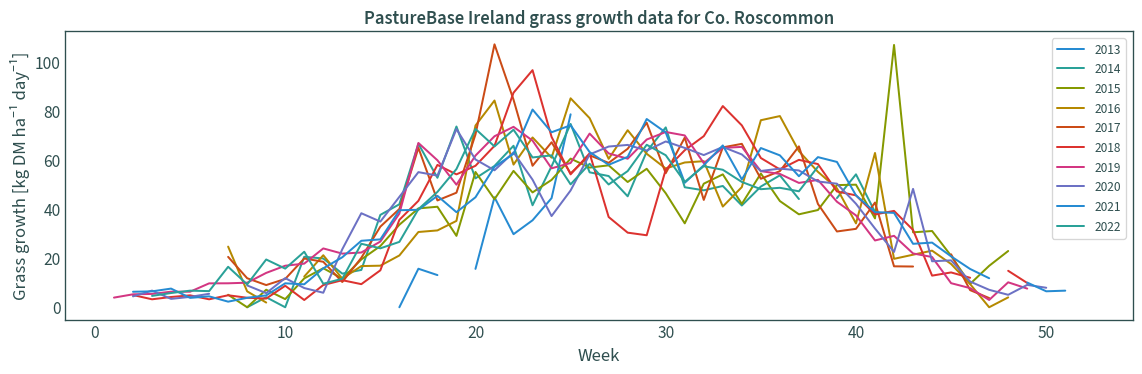

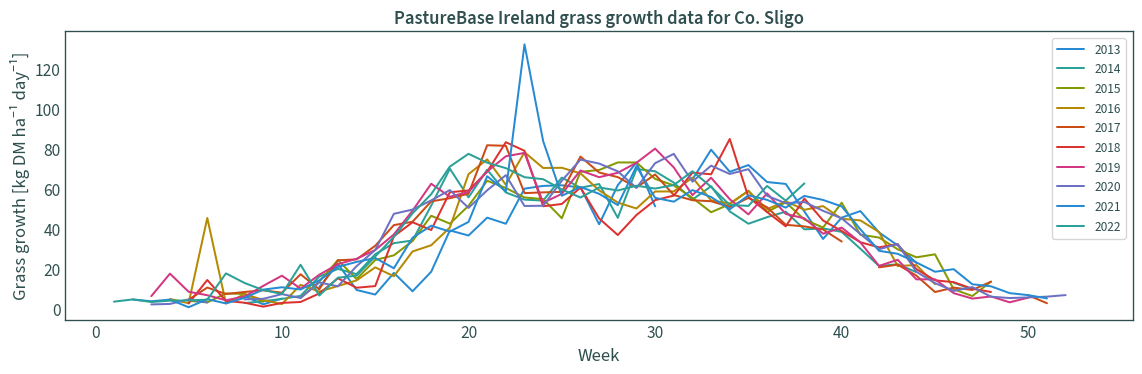

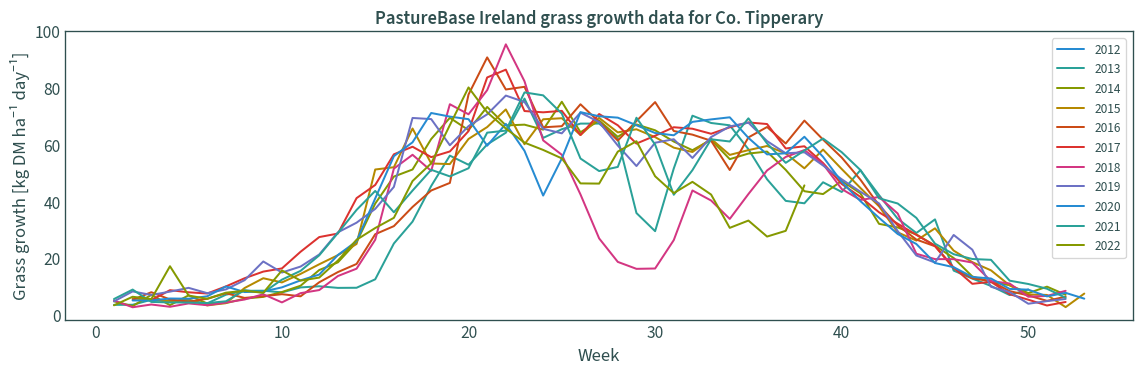

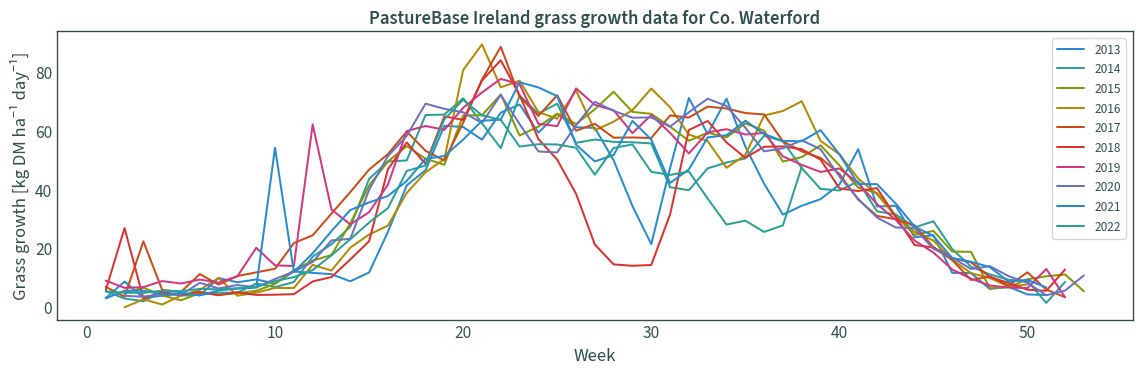

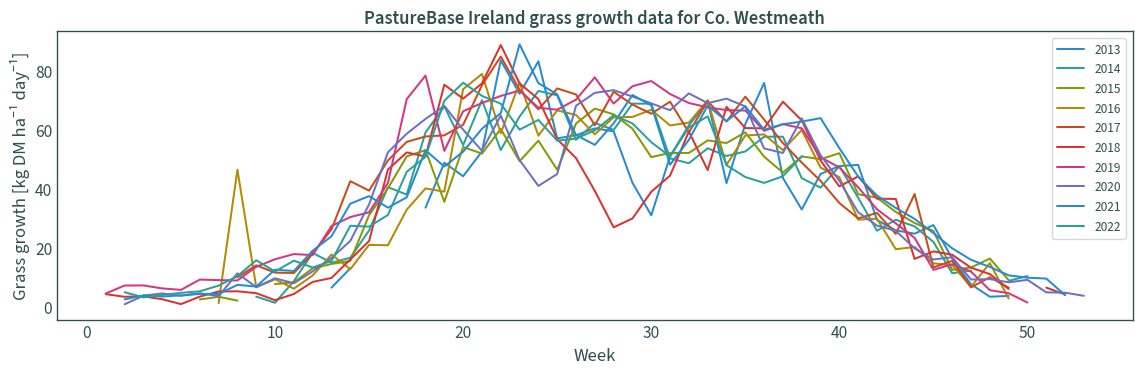

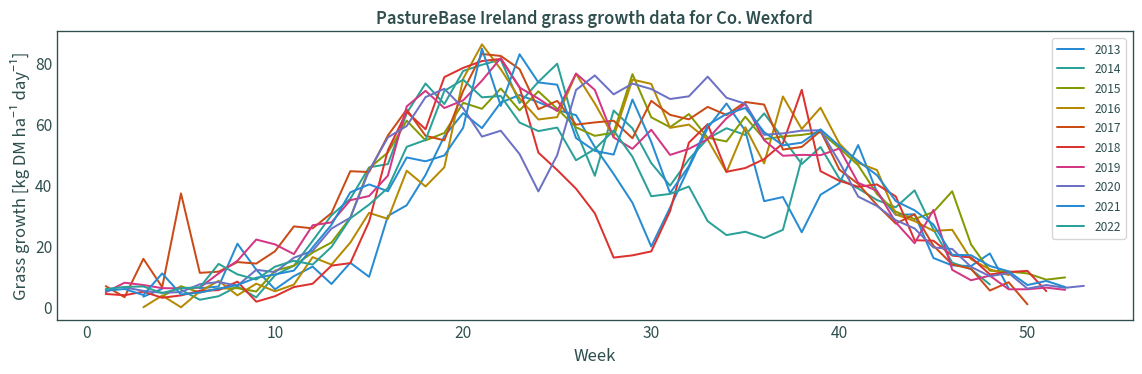

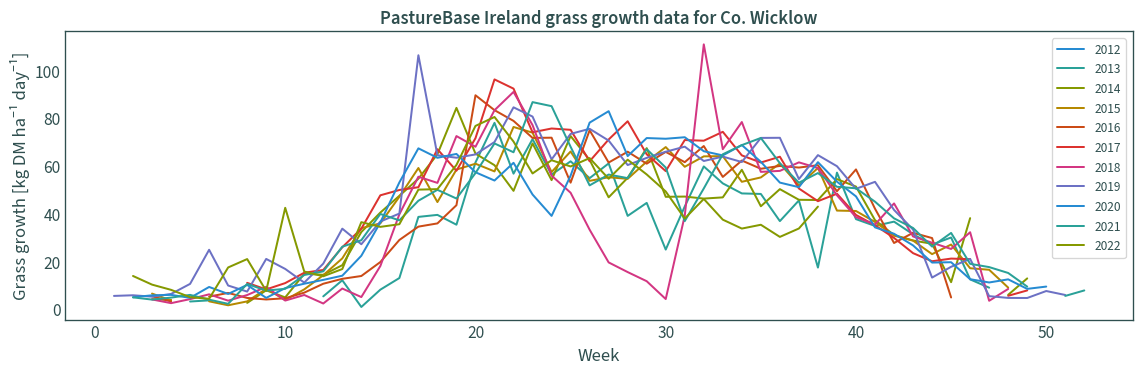

In [154]:
for county in counties:
    grass_piv[county].plot(
        figsize=(12, 4),
        xlabel="Week",
        ylabel="Grass growth [kg DM ha⁻¹ day⁻¹]",
    )
    plt.title(f"PastureBase Ireland grass growth data for Co. {county}")
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

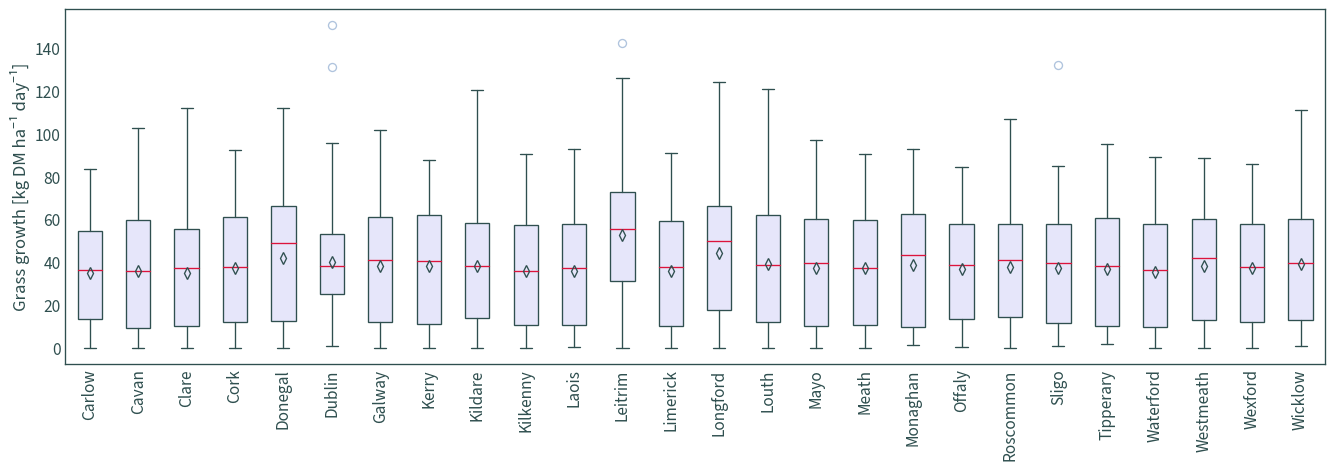

In [162]:
# with outliers
grass_piv = pd.pivot_table(
    grass_filter[["variable", "value"]].reset_index(),
    values="value",
    index=["time"],
    columns=["variable"],
)
grass_piv.plot.box(
    figsize=(14, 5),
    showmeans=True,
    patch_artist=True,
    color={
        "medians": "Crimson",
        "whiskers": "DarkSlateGrey",
        "caps": "DarkSlateGrey",
    },
    boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
    meanprops={
        "markeredgecolor": "DarkSlateGrey",
        "marker": "d",
        "markerfacecolor": (1, 1, 0, 0),  # transparent
    },
    flierprops={"markeredgecolor": "LightSteelBlue", "zorder": 1},
)
plt.xticks(rotation="vertical")
plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.tight_layout()
# plt.savefig(
#     os.path.join(
#         "data", "grass_growth", "pasturebase", "boxplot_outliers.png"
#     )
# )
plt.show()

In [166]:
grass_filter = grass_filter.rename(columns={"variable": "county"})
grass_filter.to_csv(
    os.path.join(
        "data", "grass_growth", "pasturebase", "pasturebase_cleaned.csv"
    )
)

In [167]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-04-17 08:09:24.554746+00:00


In [40]:
### Using boxplot stats

In [37]:
# grass_out = grass_ts.copy()
# for col in counties:
#     grass_out[[col]] = grass_out[[col]].replace(
#         list(boxplot_stats(grass_out[[col]].dropna())[0]["fliers"]), np.nan
#     )

In [38]:
# grass_out.plot.box(
#     figsize=(14, 5), showmeans=True, patch_artist=True,
#     color={
#         "medians": "Crimson",
#         "whiskers": "DarkSlateGrey",
#         "caps": "DarkSlateGrey"
#     },
#     boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
#     meanprops={
#         "markeredgecolor": "DarkSlateGrey",
#         "marker": "d",
#         "markerfacecolor": (1, 1, 0, 0)  # transparent
#     },
#     flierprops={"markeredgecolor": "LightSteelBlue", "zorder": 1}
# )
# plt.xticks(rotation="vertical")
# plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
# plt.tight_layout()
# # plt.savefig(
# #     os.path.join("data", "grass_growth", "pasturebase", "boxplot.png")
# # )
# plt.show()

In [35]:
# grass_out.diff().hist(figsize=(15, 18), bins=50, grid=False)
# plt.tight_layout()
# plt.savefig(
#     os.path.join("data", "grass_growth", "pasturebase", "diff_hist.png")
# )
# plt.show()

In [36]:
### Filtering outliers using 3-week moving average

In [98]:
# grass_out = grass_ts.reset_index()

In [99]:
# for county in counties:
#     mn = grass_out.rolling(3, center=True, on="time")[county].median()
#     # mn = grass_out.rolling(3, center=True, on="time")[county].mean()
#     # sd = grass_out.rolling(3, center=True, on="time")[county].std()
#     grass_out[f"{county}_outlier"] = (
#         grass_out[county].sub(mn).abs().gt(25)
#     )
#     grass_out[f"{county}_mn"] = mn
#     # grass_out[f"{county}_sd"] = sd
#     # grass_out[f"{county}_f"] = np.nan
#     # grass_out[f"{county}_f"] = grass_out[
#     #     (
#     #         grass_out[county] <=
#     #         grass_out[f"{county}_mn"] + 2 * grass_out[f"{county}_sd"]
#     #     ) & (
#     #         grass_out[county] >=
#     #         grass_out[f"{county}_mn"] - 2 * grass_out[f"{county}_sd"]
#     #     )
#     # ][[county]]
#     # grass_out[f"{county}_f"] = grass_out[
#     #     grass_out[f"{county}_f"].isna()
#     # ][[county]]

In [100]:
# grass_out.set_index("time", inplace=True)

In [33]:
# for county in counties:
#     axs = grass_out.plot(
#         # ylim=[0.0, 200.0],
#         figsize=(10, 4), y=county, label="growth"
#     )
#     grass_out.plot(
#         figsize=(10, 4), y=f"{county}_mn", ax=axs, label="moving_avg",
#         color="orange", zorder=1
#     )
#     # grass_out.plot(
#     #     figsize=(10, 4), y=f"{county}_f", ax=axs, label="f",
#     #     color="purple", linewidth=0.0, marker="*"
#     # )
#     if True in list(grass_out[f"{county}_outlier"].unique()):
#         grass_out[grass_out[f"{county}_outlier"] == True].plot(
#             ax=axs, linewidth=0.0, marker="*", y=county, label="outlier",
#             color="crimson"
#         )
#     plt.title(f"PastureBase Ireland grass growth data for Co. {county}")
#     plt.xlabel("")
#     plt.tight_layout()
#     plt.show()

In [34]:
# for county in counties:
#     axs = grass_out.plot(
#         # ylim=[0.0, 200.0],
#         figsize=(10, 4), y=county, label="growth"
#     )
#     grass_out.plot(
#         figsize=(10, 4), y=f"{county}_mn", ax=axs, label="moving_avg",
#         color="orange", zorder=1
#     )
#     if True in list(grass_out[f"{county}_outlier"].unique()):
#         grass_out[grass_out[f"{county}_outlier"] == True].plot(
#             ax=axs, linewidth=0.0, marker="*", y=county, label="outlier",
#             color="crimson"
#         )
#     plt.title(f"PastureBase Ireland grass growth data for Co. {county}")
#     plt.xlabel("")
#     plt.tight_layout()
#     plt.show()

In [32]:
# for county in counties:
#     axs = grass_out.loc["2017":"2019"].plot(
#         ylim=[0.0, 150.0],
#         figsize=(12, 8), y=county, label="growth"
#     )
#     grass_out.loc["2017":"2019"].plot(
#         figsize=(10, 4), y=f"{county}_mn", ax=axs, label="moving_avg",
#         color="orange", zorder=1
#     )
#     if True in list(
#         grass_out[f"{county}_outlier"].loc["2017":"2019"].unique()
#     ):
#         grass_out[
#             grass_out[f"{county}_outlier"] == True
#         ].loc["2017":"2019"].plot(
#             ax=axs, linewidth=0.0, marker="*", y=county, label="outlier",
#             color="crimson"
#         )
#     plt.title(f"PastureBase Ireland grass growth data for Co. {county}")
#     plt.xlabel("")
#     plt.tight_layout()
#     plt.show()